# Modelos con Pycaret

In [1]:
# Import libraries
import pycaret
from pycaret import classification as pyc
#from pycaret.utils import enable_colab
#enable_colab()
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import requests
import warnings
warnings.filterwarnings('always')

## Descargar datos

In [2]:
# download the dataset
# directory of the raw data files
_data_root = './data/covertype'

# path to the raw training data
_data_filepath = os.path.join(_data_root, 'covertype_train.csv')

## Download data
os.makedirs(_data_root, exist_ok=True)
if not os.path.isfile(_data_filepath):
    #https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/
    url = 'https://docs.google.com/uc?export=download&confirm={{VALUE}}&id=1zZkMC3opeYnYPMd-oDRUgprpPcmUgj1t'
    r = requests.get(url, allow_redirects=True, stream=True)
    open(_data_filepath, 'wb').write(r.content)

In [3]:
# Check some data
df = pd.read_csv(_data_filepath, index_col=False)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,3126,297,19,210,66,1500,162,230,207,2374,Commanche,C7757,1
1,2892,53,9,0,0,3829,226,221,129,2659,Rawah,C7202,1
2,2637,334,12,467,78,658,192,224,171,977,Commanche,C4704,2
3,2882,32,13,376,66,3618,216,211,128,3072,Rawah,C7102,1
4,2747,59,11,127,14,2701,228,216,119,4723,Rawah,C7700,1


## Procesamiento
La función `setup` permite realizar procesamiento, solo es necesario definir el origen de datos y la variable objetivo. El resto de parámetros son opcionales y se usan según la necesidad.
- `session_id` define una semilla, esto para que los experimentos sean reproducibles.
- `train_size` define porcentaje utilizado para entrenamiento y test
- `normalize` define que se realizará normalizacion a las variables, por defecto 'zscore'
- `transformation` define que se realice transformacion de datos para buscar una distribución más 'gaussiana'
- `remove_multicollinearity` cuando se detecten variables en donde la Colinealidad supere un threshold se eliminara
- `multicollinearity_threshold` define el threshold a superar la colinealidad
- `log_experiment` almacena información del experimento para poder hacer seguimiento
- `experiment_name` Asigna nombre del experimento para poder identificarlo
- `categorical_features` transforma cada valor del dominio de la variable pasa a ser una variable

In [4]:
exp_cov_1 = pyc.setup(data = df, target = 'Cover_Type', 
            session_id=42, train_size = 0.8,
            normalize = True, 
            transformation = True,
            remove_multicollinearity = True, multicollinearity_threshold = 0.9,
            log_experiment = True, experiment_name = 'Cover_Type1',
            categorical_features = ['Wilderness_Area', 'Soil_Type'],
            verbose = True) 

,Description,Value
0,Session id,42
1,Target,Cover_Type
2,Target type,Multiclass
3,Original data shape,"(464809, 13)"
4,Transformed data shape,"(464809, 16)"
5,Transformed train set shape,"(371847, 16)"
6,Transformed test set shape,"(92962, 16)"
7,Numeric features,10
8,Categorical features,2
9,Preprocess,True


Toda la información se encuentra en la variable `exp_cov_1` vale la pena revisar el contenido, existe información de pipeline, datos, distribuciones, transformaciones y modelos predefinidos.

### Revisar modelos disponibles para clasificación

In [5]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


# Comparar modelos AutoML

La función `compare_models` permite realizar autoML entre los modelos disponibles, sin embargo es posible incluir `include` o excluir `exclude` cualquiera de los modelos.

Tambien es posible ordenar los resultados usando `sort`para cualquiera de las metricas disponibles `Accuracy`, `AUC` ,`Recall` ,`Prec.`, `F1` ,`Kappa` ,`MCC`

In [6]:
best_model = pyc.compare_models(include=['dt','ada', 'rf', 'nb', 'dummy'], sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9529,0.0000,0.9529,0.9530,0.9526,0.9240,0.9242,17.8610
dt,Decision Tree Classifier,0.9301,0.0000,0.9301,0.9301,0.9301,0.8877,0.8877,2.5030
ada,Ada Boost Classifier,0.4823,0.0000,0.4823,0.5870,0.4970,0.2665,0.2811,5.5000
dummy,Dummy Classifier,0.4875,0.0000,0.4875,0.2376,0.3195,0.0000,0.0000,1.2610
nb,Naive Bayes,0.2876,0.0000,0.2876,0.3072,0.2842,0.1788,0.2492,1.2930


In [7]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Una vez definido el mejor modelo, este puede tunearse aún más, no con híper parámetros estandar, sino con una busqueda fina de los valores.

In [8]:
tuned_best = pyc.tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7737,0.0000,0.7737,0.7783,0.7637,0.6277,0.6292
1,0.7734,0.0000,0.7734,0.7774,0.7624,0.6270,0.6287
2,0.7744,0.0000,0.7744,0.7800,0.7636,0.6290,0.6306
3,0.7699,0.0000,0.7699,0.7748,0.7589,0.6217,0.6232
4,0.7729,0.0000,0.7729,0.7782,0.7620,0.6270,0.6283
5,0.7711,0.0000,0.7711,0.7752,0.7602,0.6233,0.6249
6,0.7742,0.0000,0.7742,0.7788,0.7633,0.6286,0.6302
7,0.7696,0.0000,0.7696,0.7733,0.7584,0.6208,0.6224
8,0.7701,0.0000,0.7701,0.7727,0.7586,0.6213,0.6229


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Revisar resultados
Es posible revisar de manera independiente o de manera dinamica

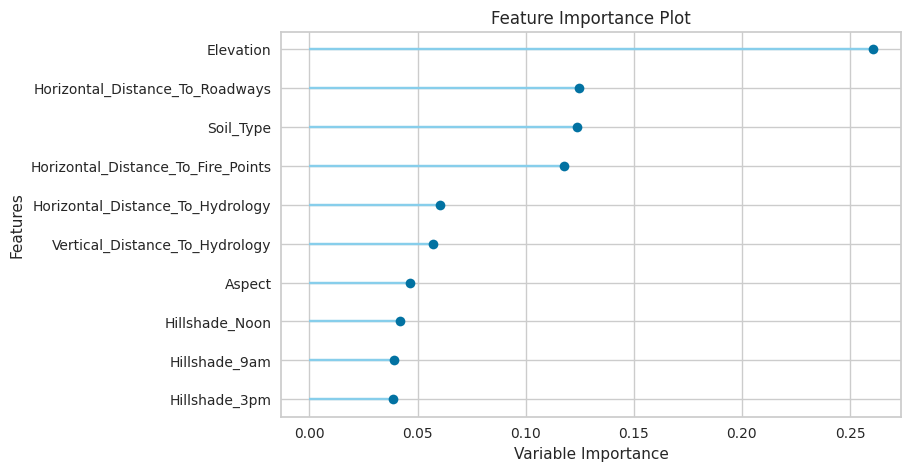

In [9]:
# check feature importance
pyc.plot_model(tuned_best, plot = 'feature')

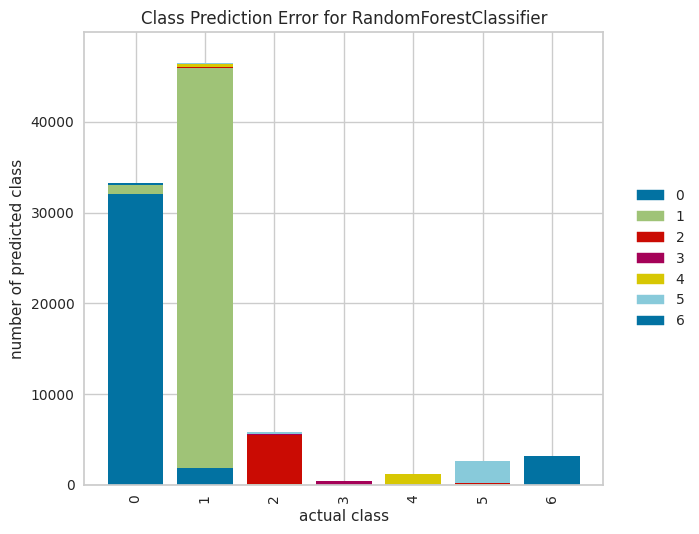

In [10]:
pyc.plot_model(tuned_best, plot = 'error')

In [11]:
pyc.evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Esta función predice usando el modelo entrenado. Cuando los datos son ´None´, predice la etiqueta y la puntuación en el conjunto de prueba (creado durante la función de configuración).

Antes de finalizar el modelo, se recomienda realizar una verificación final prediciendo el conjunto de prueba (test) y revisando las métricas de evaluación. Todas las métricas de evaluación que hemos visto anteriormente son resultados de validación cruzada basados **solo en el conjunto de entrenamiento (80%)**. Ahora, vamos a utilizar los datos de test para ver si el rendimiento es diferentes y puede haber overfitting.

# Guardar modelo para inferencia

In [12]:
# finalize the model
final_best = pyc.finalize_model(tuned_best)

# save model to disk
pyc.save_model(final_best, 'model_cover_type')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Elevation', 'Aspect', 'Slope',
                                              'Horizontal_Distance_To_Hydrology',
                                              'Vertical_Distance_To_Hydrology',
                                              'Horizontal_Distance_To_Roadways',
                                              'Hillshade_9am', 'Hillshade_Noon',
                                              'Hillshade_3pm',
                                              'Horizontal_Distance_To_Fire_Points'],
                                     transformer=SimpleImputer...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                          

## Usar nuevos datos para Inferencia con el modelo Guardado

Descarga nuevo conjunto de datos.

In [13]:
# download the dataset
# directory of the raw data files
_data_root = './data/covertype'

# path to the raw training data
_data_filepath_test = os.path.join(_data_root, 'covertype_test.csv')

## Download data
os.makedirs(_data_root, exist_ok=True)
if not os.path.isfile(_data_filepath_test):
    #https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/
    url = 'https://docs.google.com/uc?export=download&confirm={{VALUE}}&id=1lVF1BCWLH4eXXV_YOJzjR7xZjj-wAGj9'
    r = requests.get(url, allow_redirects=True, stream=True)
    open(_data_filepath_test, 'wb').write(r.content)

Carga modelo previamente almacenado

In [14]:
saved_model = pyc.load_model('model_cover_type')

Transformation Pipeline and Model Successfully Loaded


In [15]:
df_test = pd.read_csv(_data_filepath_test, index_col=False)

#### Validar predicción

In [16]:
new_prediction = pyc.predict_model(saved_model, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9594,0.9962,0.9594,0.9595,0.9593,0.9346,0.9347
